Deep Learning Project

Detecting Driver Drowsiness

In [1]:
import numpy as np
import math
import sys 
import os
import shutil
import sklearn
import os.path
import csv
from glob import glob
import h5py as h5py
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from functools import partial
import PIL
import PIL.Image
from sklearn.datasets import load_files       
from keras.utils import np_utils

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,SpatialDropout2D,MaxPooling2D
from tensorflow.keras.layers import Flatten,RandomRotation,RandomContrast,RandomFlip,GaussianNoise
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,Dropout,AveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, EfficientNetB1, VGG16, EfficientNetB0
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

## OpenCV computer vision package to be utilzied for object (face & eyes) detection
import cv2
## cv2.imshow() disabled in Colab; importing substitute method
from google.colab.patches import cv2_imshow
## Want to use distance library to create an eye aspect ratio function which will be utilized
## to compute the ratio of distances between vertical eye landmarks & the horizontal
## distance within eyes
from scipy.spatial import distance
import dlib

### After experimenting with various techniques
### the below library was found to be the "best"
### face detector in terms of number of true positives
### detected faces at many angles that haar, MTCNN and dlib missed
!pip install cvlib
import cvlib as cv

     |████████████████████████████████| 10.0 MB 6.7 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.6-py3-none-any.whl size=10044619 sha256=eebcef8556ef7dc158e51f6969dd3d6f9010ff65215754b78a9a96c95e234859
  Stored in directory: /root/.cache/pip/wheels/9b/96/9b/373c07517ffe0bedbebc0813aec1e62cb2bb1dee91b3694895
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=76f64b2253fbc08476081cebf3701f03fd081c385fc78ba14907f55431b77000
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
np.random.seed(49) 
tf.random.set_seed(49)

In [4]:
## https://www.kaggle.com/general/51898
!pip install kaggle
# import kaggle

In [5]:
# ! mkdir ~/.kaggle
## Change to my drive directory
! cd /content/drive/MyDrive/

In [6]:
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
## Configure kaggle json file
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/"

In [7]:
! kaggle datasets download dheerajperumandla/drowsiness-dataset

 90% 145M/161M [00:01<00:00, 122MB/s]
100% 161M/161M [00:01<00:00, 151MB/s]


In [8]:
drowsiness_dataset= ! unzip drowsiness-dataset.zip

In [9]:
labels = os.listdir("train")
labels
## Will want to convert to drowsy (yawn, Open) and awake (no_yawn, Closed)

['Closed', 'no_yawn', 'yawn', 'Open']

Closed Eye Image Shape is (102, 124, 3)


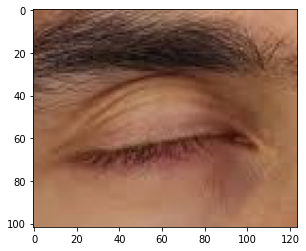

In [10]:
closer = plt.imread("train/Closed/_5.jpg")
plt.imshow(closer)
print("Closed Eye Image Shape is", closer.shape)

Yawning Mouth Image Shape is (480, 640, 3)


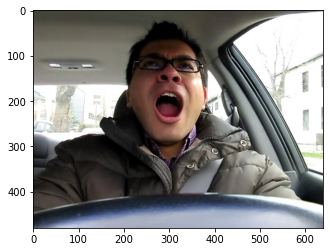

In [11]:
yawny = plt.imread("train/yawn/32.jpg")
plt.imshow(yawny)
print("Yawning Mouth Image Shape is", yawny.shape)

In [12]:
## Make new directories for awake & droswy
## and move respective files to them
!mkdir train/awake
!mkdir train/drowsy

!mv  -v train/Closed train/drowsy
!mv  -v train/yawn train/drowsy
!mv  -v train/Open train/awake
!mv  -v train/no_yawn train/awake

renamed 'train/Closed' -> 'train/drowsy/Closed'
renamed 'train/yawn' -> 'train/drowsy/yawn'
renamed 'train/Open' -> 'train/awake/Open'
renamed 'train/no_yawn' -> 'train/awake/no_yawn'


In [13]:
## Code block to rename/move images
## to correspond to awake and drowsy
# noya = 'train/'+os.listdir('train')[1]
# os.rename(noya, 'train/awake')
# ya = 'train/'+os.listdir('train')[2]
# os.rename(ya, 'train/drowsy')
# !find train/Open -type f -print0 | xargs -0 mv -t train/awake
# shutil.rmtree('train/Open')
# !find train/Closed -type f -print0 | xargs -0 mv -t train/drowsy
# shutil.rmtree('train/Closed')

In [14]:
labs = os.listdir("train")
labs

['drowsy', 'awake']

Closed Eye Image Shape is (102, 124, 3)


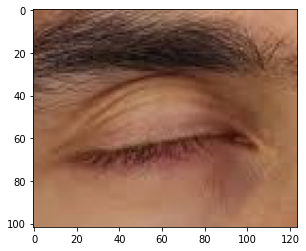

In [15]:
tired = plt.imread("train/drowsy/Closed/_5.jpg")
plt.imshow(tired)
print("Closed Eye Image Shape is", tired.shape)

Closed Mouth Image Shape is (480, 640, 3)


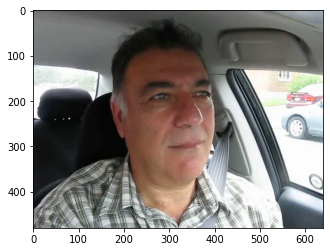

In [16]:
wakey = plt.imread("train/awake/no_yawn/1120.jpg")
plt.imshow(wakey)
print("Closed Mouth Image Shape is", wakey.shape)

Exploring below

In [17]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "train"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 2900 files belonging to 2 classes.
Using 2320 files for training.
Found 2900 files belonging to 2 classes.
Using 580 files for validation.


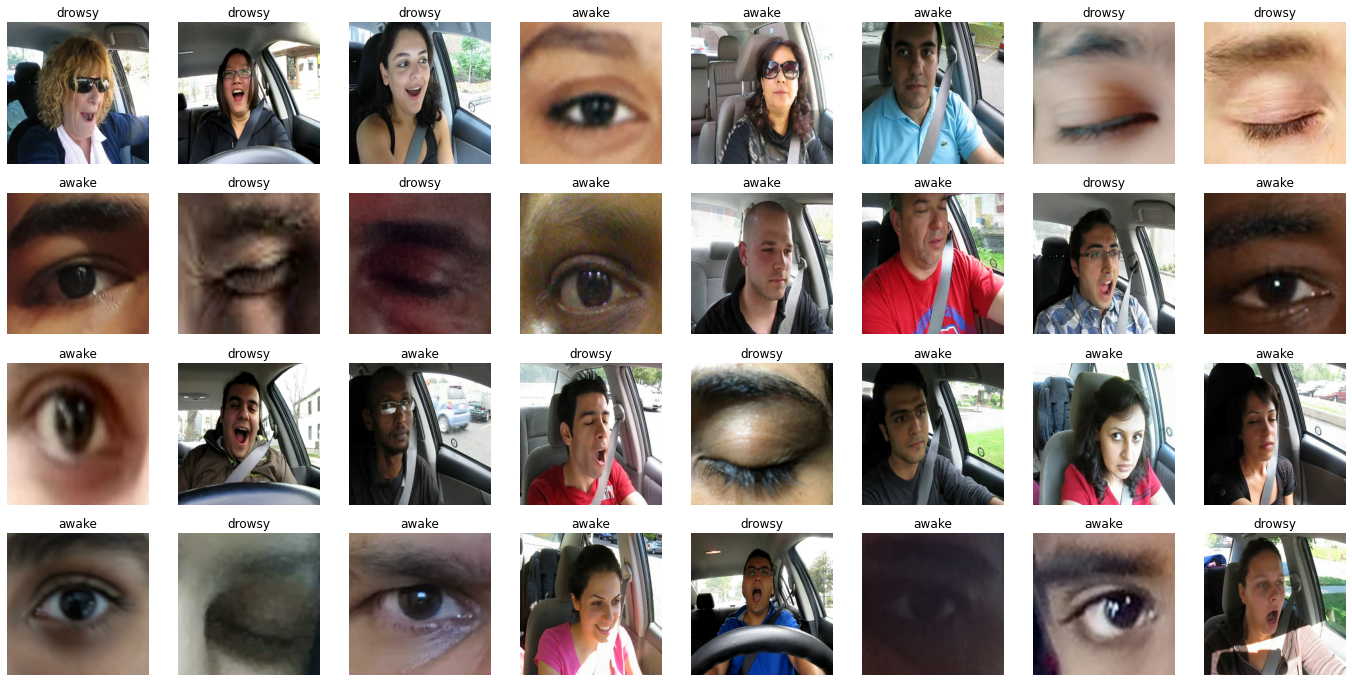

In [18]:
# Visualize some of the train samples of one batch

## Use if we don't reclassify images
#class_names = ['Closed', 'Open', 'no_yawn', 'yawn']
class_names = ['awake', 'drowsy']

# Rows and columns are set to fit one training batch (32)
n_rows = 4
n_cols = 8
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [19]:
train_size = len(train_ds.file_paths)
val_size = len(validation_ds.file_paths)
n_classes = len(class_names)

In [ ]:
## Load pre-trained model & add additional layers
base_model = ResNet50(weights="imagenet",include_top=False, input_shape=(299, 299, 3))
dro = SpatialDropout2D(0.1)(base_model.output)
maxy = GlobalMaxPooling2D()(dro)
output = Dense(n_classes, activation="softmax")(maxy)
model = Model(inputs=base_model.input, outputs=output)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=10)

Epoch 1/10
73/73 [==============================] - 22s 156ms/step - loss: 117.5132 - accuracy: 0.7336 - val_loss: 63.0134 - val_accuracy: 0.7707
Epoch 2/10
73/73 [==============================] - 10s 138ms/step - loss: 12.2642 - accuracy: 0.9022 - val_loss: 2.7588 - val_accuracy: 0.9621
Epoch 3/10
73/73 [==============================] - 10s 138ms/step - loss: 6.3568 - accuracy: 0.9328 - val_loss: 9.2147 - val_accuracy: 0.9224
Epoch 4/10
73/73 [==============================] - 10s 138ms/step - loss: 3.7557 - accuracy: 0.9534 - val_loss: 1.7792 - val_accuracy: 0.9810
Epoch 5/10
73/73 [==============================] - 10s 138ms/step - loss: 2.8898 - accuracy: 0.9629 - val_loss: 2.8272 - val_accuracy: 0.9741
Epoch 6/10
73/73 [==============================] - 10s 138ms/step - loss: 2.5828 - accuracy: 0.9599 - val_loss: 1.9372 - val_accuracy: 0.9741
Epoch 7/10
73/73 [==============================] - 10s 138ms/step - loss: 1.9305 - accuracy: 0.9698 - val_loss: 1.7735 - val_accuracy: 0.

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.RMSprop(learning_rate=0.0000001, momentum=0.9, decay=0.000001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=15)

Epoch 1/15
73/73 [==============================] - 32s 355ms/step - loss: 12.2321 - accuracy: 0.8879 - val_loss: 5.5472 - val_accuracy: 0.9500
Epoch 2/15
73/73 [==============================] - 25s 338ms/step - loss: 7.1108 - accuracy: 0.9207 - val_loss: 5.2099 - val_accuracy: 0.9448
Epoch 3/15
73/73 [==============================] - 25s 339ms/step - loss: 5.4382 - accuracy: 0.9319 - val_loss: 6.2773 - val_accuracy: 0.9379
Epoch 4/15
73/73 [==============================] - 25s 338ms/step - loss: 4.0702 - accuracy: 0.9487 - val_loss: 7.8834 - val_accuracy: 0.9379
Epoch 5/15
73/73 [==============================] - 25s 338ms/step - loss: 3.2598 - accuracy: 0.9603 - val_loss: 8.6655 - val_accuracy: 0.9466
Epoch 6/15
73/73 [==============================] - 25s 340ms/step - loss: 2.2175 - accuracy: 0.9642 - val_loss: 8.6943 - val_accuracy: 0.9517
Epoch 7/15
73/73 [==============================] - 25s 339ms/step - loss: 2.0519 - accuracy: 0.9707 - val_loss: 8.1416 - val_accuracy: 0.956

PreProcessing Draft - Plan to experiment with additionally

In [20]:
## This dataset contains 2 files (among others): 
## haar cascade XML files for face & eye detection
## These classififers can be used with cv2.CascadeClassifier
## for face and eyes detection
## ! kaggle datasets download adinishad/prediction-images
## prediction_images= ! unzip prediction-images.zip
## Changed dataset source to one that includes all
## haar cascade files (17), including one for mouth
! kaggle datasets download delllectron/haarcascades
haarcascades = ! unzip haarcascades.zip
## Per the below link, while haarcascade_smile.xml
## filename suggests that this model is a “smile detector,” 
## actually detects the presence of the “mouth” on a face
## https://www.pyimagesearch.com/2021/04/12/opencv-haar-cascades/

### Downloading MMOD CNN pre-trained model .dat file
### More Robust to angles & facial variations
# ! kaggle datasets download kevinpatel04/models
# models = ! unzip models.zip

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 96.7MB/s]


In [21]:
## Can clone openCV repository & get most recent
## haarcascades if there is an update
# ! git clone https://github.com/opencv/opencv.git

In [22]:
## Define non-maximum suppresion function from below
## https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def nmx(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,0] + boxes[:,2] + boxes[:,3]
	y2 = boxes[:,1] + boxes[:,3] + boxes[:,2]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [23]:
def face_for_yawn(data_dir="train", eye_cas_path="haarcascade_eye.xml", mouthy="haarcascade_smile.xml"):
    yawn_no = []
    IMG_SIZE = 299
    categories = ["drowsy/yawn", "awake/no_yawn"]
    ## establish path to pull images from
    for category in categories:
        path_link = os.path.join(data_dir, category)
        ## Classes for each category; 0: drowsy, 1: awake
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            ## Set eye classifier; won't use since some droswy faces have open eyes
            ## and some awake faces have closed eyes; have close up eye images separately
            eye_cascade = cv2.CascadeClassifier(eye_cas_path)
            ## Set mouth classifier
            mouth_cascade = cv2.CascadeClassifier(mouthy)
            ## Perform face detection on images
            ## Returns an array of detections with x,y coordinates
            faces, confidences = cv.detect_face(image_array)
            ## Iterate over the images and draw boundary boxes for each face
            for face,conf in zip(faces,confidences):
                (x,y) = face[0],face[1]
                (x1,y1) = face[2],face[3]
                h = y1 - y
                w = x1 - x
                img = cv2.rectangle(image_array, (x, y), (x1, y1), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                ## Resize image
                ## Images 276-279 & 2606 not detecting bounding boxes, so size=0
                ## Resize whole image and add instead
                try:
                  resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                except:
                  resized_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                ## Add resized image to yawn_no_yawn array with 0 for drowst, 1 for awake
                yawn_no.append([resized_array, class_num1])
                ## Use only bottom half of face for mouth detection
                mroi = img[y+int(h*0.55):y+h, x:x+w]
                mouths = mouth_cascade.detectMultiScale(mroi, 1.06, 11)
                ## perform non-maximum suppresion on mouth bounding boxes
                pickm = nmx(mouths, 0.1)
                ## Iterate over the images and draw boundary boxes for each mouth
                for (mx, my, mw, mh) in pickm:
                  mimg = cv2.rectangle(mroi,(mx,my),(mx+mw,my+mh),(0,0,255),1)
                  roi_mouth = mimg[my:my+mh, mx:mx+mw]
                  resized_mouth = cv2.resize(roi_mouth, (IMG_SIZE, IMG_SIZE))
                  yawn_no.append([resized_mouth, class_num1])
                ## possibly resize/crop mouth image and save as separate feature
                
    return yawn_no

yawn_no_yawn = face_for_yawn()

0
1


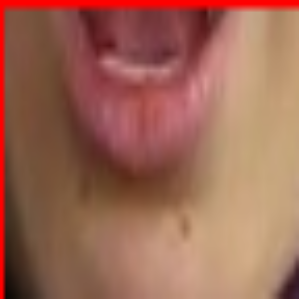

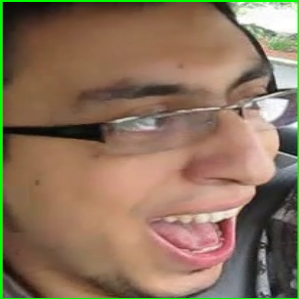

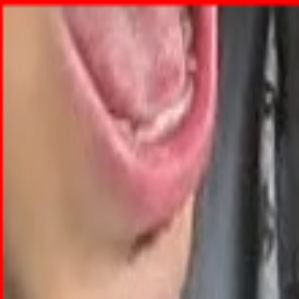

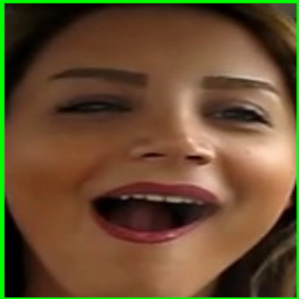

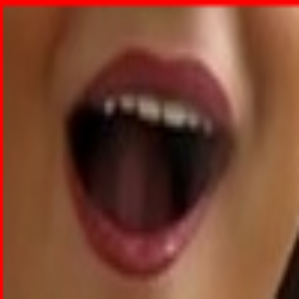

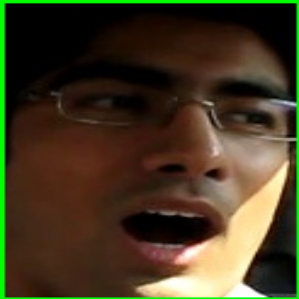

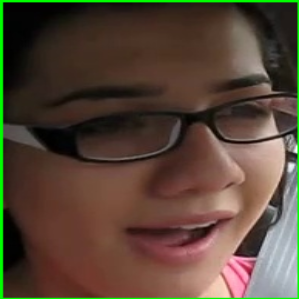

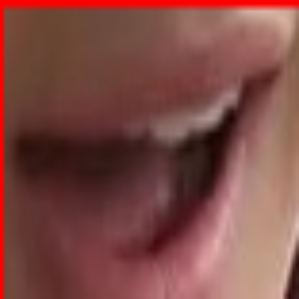

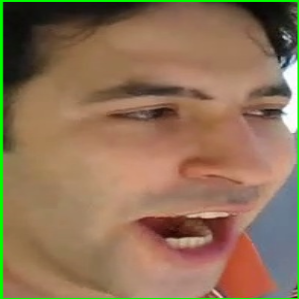

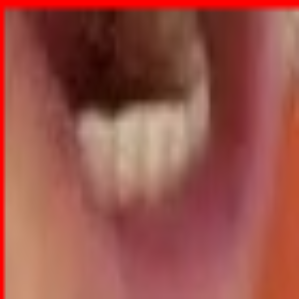

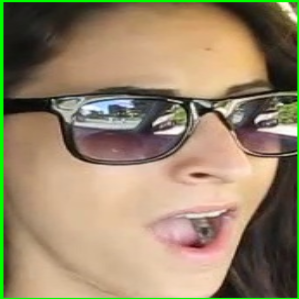

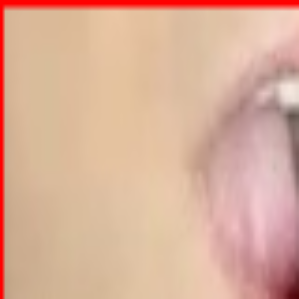

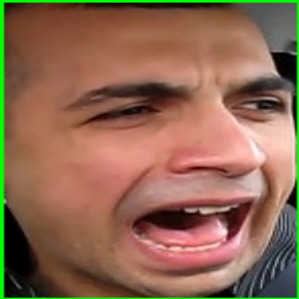

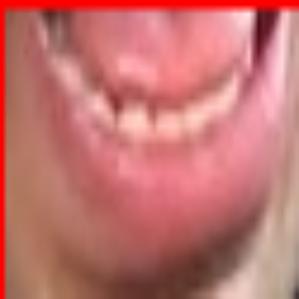

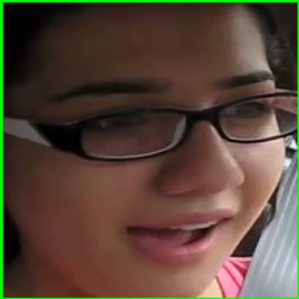

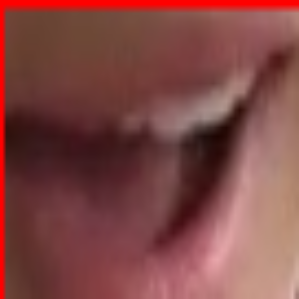

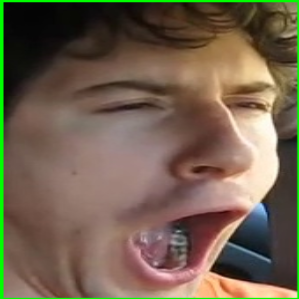

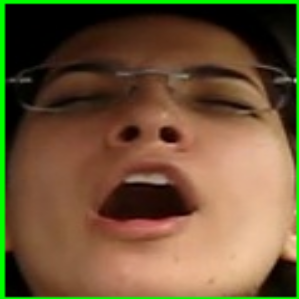

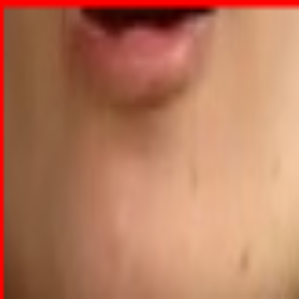

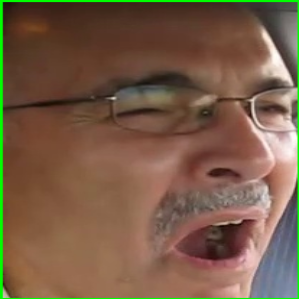

In [24]:
for i in range(11,31):
  cv2_imshow(yawn_no_yawn[i][0])

In [ ]:
## Eye images are close up and labeled, so haar casdace won't be helpful
## Resize closed and open eyes images & add them to
## array with corresponding label; 0: drowsy Eyes, 1: awake Eyes
def open_close_eyes(data_dir="train"):
    labels = ['drowsy/Closed', 'awake/Open']
    IMG_SIZE = 299
    eyes_data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                eyes_data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return eyes_data

eyes_no_eyes=open_close_eyes()

0
1


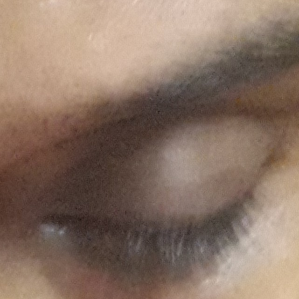

0


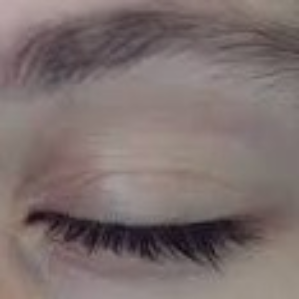

0


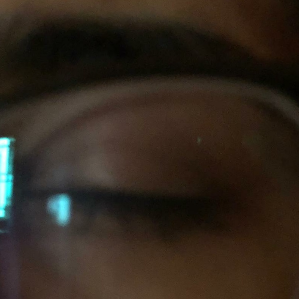

0


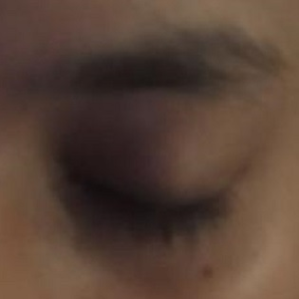

0


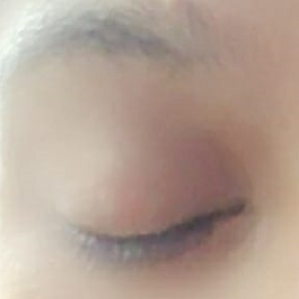

0


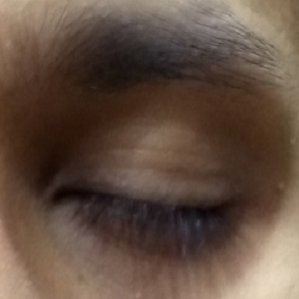

0


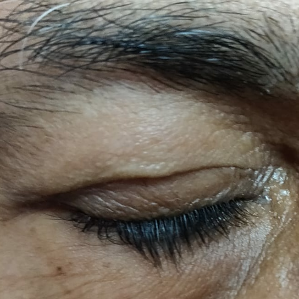

0


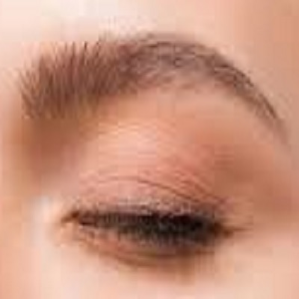

0


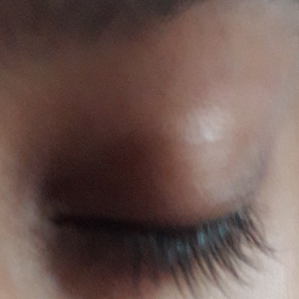

0


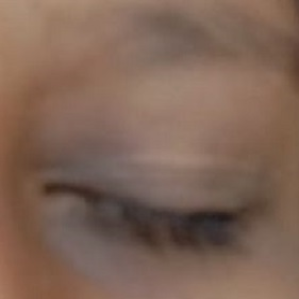

0


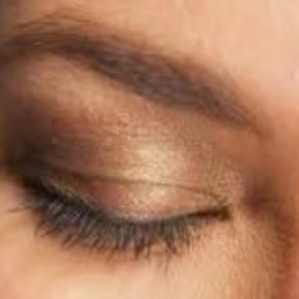

0


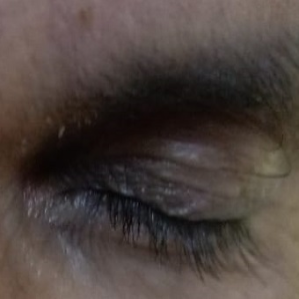

0


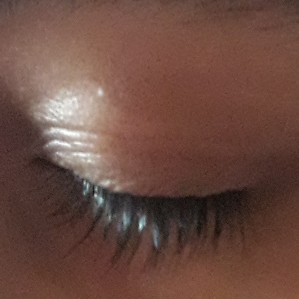

0


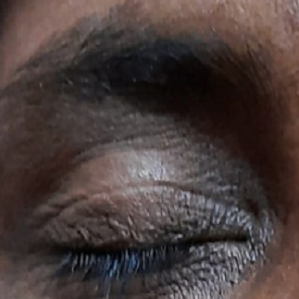

0


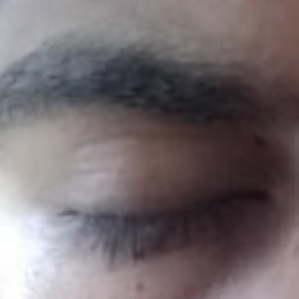

0


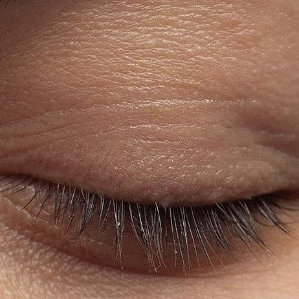

0


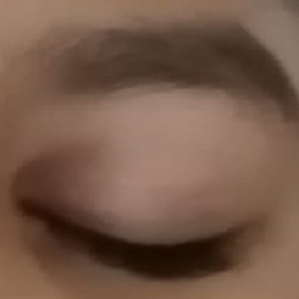

0


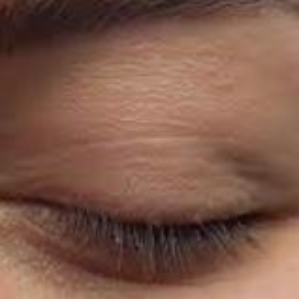

0


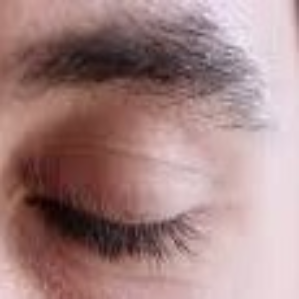

0


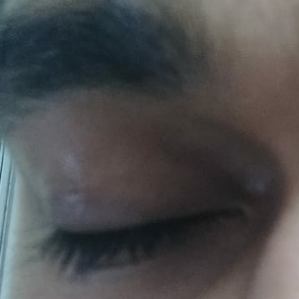

0


In [ ]:
for i in range(11,31):
  cv2_imshow(eyes_no_eyes[i][0])
  print(eyes_no_eyes[i][1])

Classification:

0: Drowsy <br>
1: Awake

In [ ]:
## Add above preprocessed data together
def append_data():
    yawn_no = face_for_yawn()
    eyes_data = open_close_eyes()
    yawn_no.extend(eyes_data)
    return np.array(yawn_no)

driver_data = append_data()

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


1
0
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
images = []
targets = []
for feature, label in driver_data:
    images.append(feature)
    targets.append(label)

In [ ]:
images = np.array(images)
images = images.reshape(-1, 299, 299, 3)
targets = np.array(targets)

In [ ]:
from sklearn.model_selection import train_test_split
seed=42
train_images, test_images, train_targets, test_targets = train_test_split(images, targets, test_size=0.2, random_state=seed)
#train_images, val_images, train_targets, val_targets = train_test_split(train_images, train_targets, test_size=0.15, random_state=seed)

In [ ]:
## data aug

train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(train_images), train_targets, shuffle=False)
test_generator = test_generator.flow(np.array(test_images), test_targets, shuffle=False)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=train_images.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
127/127 [==============================] - 69s 526ms/step - loss: 0.6040 - accuracy: 0.6681 - val_loss: 0.5230 - val_accuracy: 0.7515
Epoch 2/10
127/127 [==============================] - 66s 521ms/step - loss: 0.5060 - accuracy: 0.7581 - val_loss: 0.4524 - val_accuracy: 0.7899
Epoch 3/10
127/127 [==============================] - 66s 518ms/step - loss: 0.4530 - accuracy: 0.7909 - val_loss: 0.4255 - val_accuracy: 0.8146
Epoch 4/10
127/127 [==============================] - 66s 520ms/step - loss: 0.4151 - accuracy: 0.8183 - val_loss: 0.3432 - val_accuracy: 0.8570
Epoch 5/10
127/127 [==============================] - 66s 521ms/step - loss: 0.3904 - accuracy: 0.8274 - val_loss: 0.3422 - val_accuracy: 0.8501
Epoch 6/10
127/127 [==============================] - 66s 521ms/step - loss: 0.3725 - accuracy: 0.8360 - val_loss: 0.3008 - val_accuracy: 0.8757
Epoch 7/10
127/127 [==============================] - 66s 520ms/step - loss: 0.3415 - accuracy: 0.8526 - val_loss: 0.2945 - val_ac

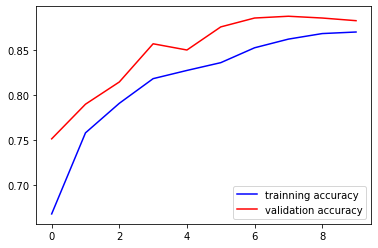

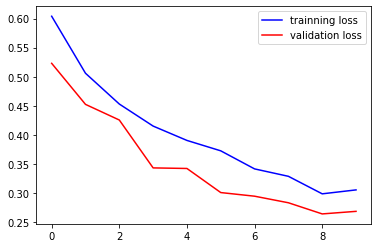

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
model.save("drowsiness_new6.h5")

RESNET


In [ ]:
model2 = keras.applications.ResNet50(weights="imagenet",
                                                  include_top=False, input_shape=(299,299,3))
avg = keras.layers.GlobalAveragePooling2D()(model2.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=model2.input, outputs=output)
## print(model.summary())

In [ ]:
for layer in model2.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,
                                 nesterov=True, decay=0.00001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, epochs=20, validation_data=test_generator, shuffle=True)

Epoch 1/20
127/127 [==============================] - 76s 559ms/step - loss: 0.6109 - accuracy: 0.6662 - val_loss: 1.8102 - val_accuracy: 0.4882
Epoch 2/20
127/127 [==============================] - 70s 548ms/step - loss: 0.4283 - accuracy: 0.8284 - val_loss: 7.2557 - val_accuracy: 0.4882
Epoch 3/20
127/127 [==============================] - 69s 545ms/step - loss: 0.3376 - accuracy: 0.8767 - val_loss: 5.7333 - val_accuracy: 0.4892
Epoch 4/20
127/127 [==============================] - 69s 542ms/step - loss: 0.2818 - accuracy: 0.8972 - val_loss: 1.6318 - val_accuracy: 0.4970
Epoch 5/20
127/127 [==============================] - 69s 545ms/step - loss: 0.2416 - accuracy: 0.9135 - val_loss: 0.8591 - val_accuracy: 0.5335
Epoch 6/20
127/127 [==============================] - 69s 543ms/step - loss: 0.2137 - accuracy: 0.9226 - val_loss: 0.7075 - val_accuracy: 0.6055
Epoch 7/20
127/127 [==============================] - 69s 542ms/step - loss: 0.1890 - accuracy: 0.9310 - val_loss: 0.5271 - val_ac

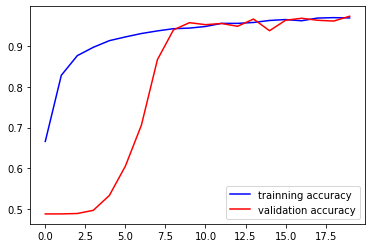

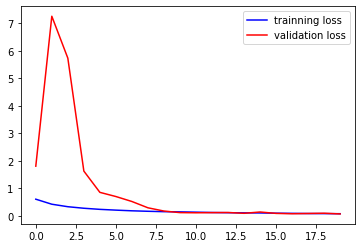

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

Inception V3

In [ ]:
model3 = keras.applications.InceptionV3(weights="imagenet",
                                                  include_top=False, input_shape=(299,299,3))
avg = keras.layers.GlobalAveragePooling2D()(model3.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=model3.input, outputs=output)
## print(model.summary())

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in model3.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,
                                 nesterov=True, decay=0.00001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, epochs=20, validation_data=test_generator, shuffle=True)

Epoch 1/20
127/127 [==============================] - 77s 548ms/step - loss: 0.6802 - accuracy: 0.5893 - val_loss: 0.6328 - val_accuracy: 0.6203
Epoch 2/20
127/127 [==============================] - 68s 533ms/step - loss: 0.5590 - accuracy: 0.7515 - val_loss: 0.5200 - val_accuracy: 0.7544
Epoch 3/20
127/127 [==============================] - 68s 532ms/step - loss: 0.4733 - accuracy: 0.8143 - val_loss: 0.4520 - val_accuracy: 0.8037
Epoch 4/20
127/127 [==============================] - 68s 532ms/step - loss: 0.4004 - accuracy: 0.8521 - val_loss: 0.3856 - val_accuracy: 0.8511
Epoch 5/20
127/127 [==============================] - 68s 533ms/step - loss: 0.3433 - accuracy: 0.8738 - val_loss: 0.3299 - val_accuracy: 0.8866
Epoch 6/20
127/127 [==============================] - 68s 532ms/step - loss: 0.3008 - accuracy: 0.8905 - val_loss: 0.2859 - val_accuracy: 0.9043
Epoch 7/20
127/127 [==============================] - 68s 532ms/step - loss: 0.2672 - accuracy: 0.9016 - val_loss: 0.2538 - val_ac

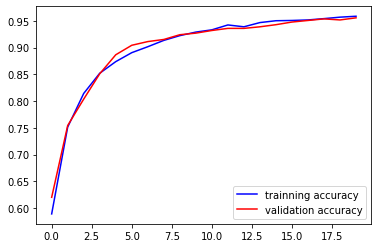

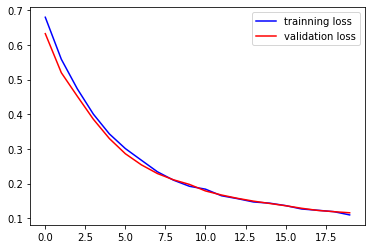

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

VGG 16

In [ ]:
model4 = keras.applications.VGG16(weights="imagenet",
                                                  include_top=False, input_shape=(299,299,3))
avg = keras.layers.GlobalAveragePooling2D()(model4.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=model4.input, outputs=output)
## print(model.summary())

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in model4.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,
                                 nesterov=True, decay=0.00001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True)

Epoch 1/10
127/127 [==============================] - 84s 609ms/step - loss: 0.6876 - accuracy: 0.5535 - val_loss: 0.6876 - val_accuracy: 0.5256
Epoch 2/10
127/127 [==============================] - 71s 553ms/step - loss: 0.6728 - accuracy: 0.6008 - val_loss: 0.6699 - val_accuracy: 0.6331
Epoch 3/10
127/127 [==============================] - 71s 553ms/step - loss: 0.6564 - accuracy: 0.6314 - val_loss: 0.6609 - val_accuracy: 0.5937
Epoch 4/10
127/127 [==============================] - 70s 551ms/step - loss: 0.6332 - accuracy: 0.6765 - val_loss: 0.6305 - val_accuracy: 0.6479
Epoch 5/10
127/127 [==============================] - 70s 550ms/step - loss: 0.5959 - accuracy: 0.7108 - val_loss: 0.5528 - val_accuracy: 0.7633
Epoch 6/10
127/127 [==============================] - 70s 549ms/step - loss: 0.5301 - accuracy: 0.7636 - val_loss: 0.5492 - val_accuracy: 0.6893
Epoch 7/10
127/127 [==============================] - 70s 548ms/step - loss: 0.4587 - accuracy: 0.7968 - val_loss: 0.3928 - val_ac

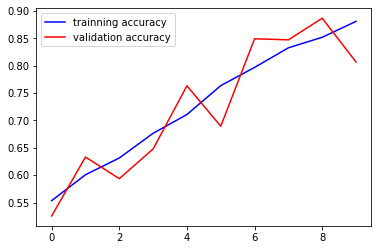

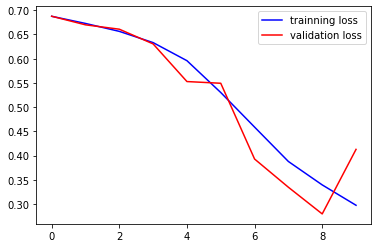

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

Xception

In [ ]:
model5 = keras.applications.Xception(weights="imagenet",
                                                  include_top=False, input_shape=(299,299,3))
avg = keras.layers.GlobalAveragePooling2D()(model5.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=model5.input, outputs=output)
## print(model.summary())

In [ ]:
for layer in model5.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True)

Epoch 1/10
127/127 [==============================] - 73s 555ms/step - loss: 0.4723 - accuracy: 0.7714 - val_loss: 0.3877 - val_accuracy: 0.8304
Epoch 2/10
127/127 [==============================] - 70s 550ms/step - loss: 0.3759 - accuracy: 0.8343 - val_loss: 0.3467 - val_accuracy: 0.8570
Epoch 3/10
127/127 [==============================] - 70s 553ms/step - loss: 0.3457 - accuracy: 0.8531 - val_loss: 0.3347 - val_accuracy: 0.8570
Epoch 4/10
127/127 [==============================] - 70s 547ms/step - loss: 0.3317 - accuracy: 0.8577 - val_loss: 0.3288 - val_accuracy: 0.8481
Epoch 5/10
127/127 [==============================] - 70s 550ms/step - loss: 0.3148 - accuracy: 0.8740 - val_loss: 0.3078 - val_accuracy: 0.8738
Epoch 6/10
127/127 [==============================] - 70s 552ms/step - loss: 0.3025 - accuracy: 0.8817 - val_loss: 0.3058 - val_accuracy: 0.8777
Epoch 7/10
127/127 [==============================] - 70s 552ms/step - loss: 0.2991 - accuracy: 0.8819 - val_loss: 0.3012 - val_ac

In [ ]:
for layer in model5.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,
                                 nesterov=True, decay=0.00001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True)

Epoch 1/10
127/127 [==============================] - 99s 749ms/step - loss: 0.4208 - accuracy: 0.8070 - val_loss: 0.3880 - val_accuracy: 0.8176
Epoch 2/10
127/127 [==============================] - 95s 743ms/step - loss: 0.3836 - accuracy: 0.8272 - val_loss: 0.3475 - val_accuracy: 0.8314
Epoch 3/10
127/127 [==============================] - 95s 743ms/step - loss: 0.3426 - accuracy: 0.8420 - val_loss: 0.3139 - val_accuracy: 0.8531
Epoch 4/10
127/127 [==============================] - 95s 743ms/step - loss: 0.3041 - accuracy: 0.8637 - val_loss: 0.2907 - val_accuracy: 0.8679
Epoch 5/10
127/127 [==============================] - 95s 743ms/step - loss: 0.2856 - accuracy: 0.8772 - val_loss: 0.2708 - val_accuracy: 0.8807
Epoch 6/10
127/127 [==============================] - 95s 743ms/step - loss: 0.2611 - accuracy: 0.8851 - val_loss: 0.2537 - val_accuracy: 0.8856
Epoch 7/10
127/127 [==============================] - 95s 743ms/step - loss: 0.2558 - accuracy: 0.8932 - val_loss: 0.2372 - val_ac

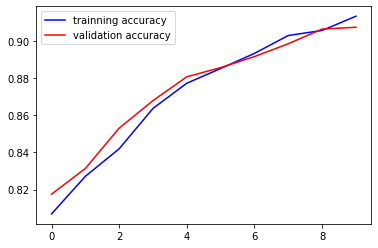

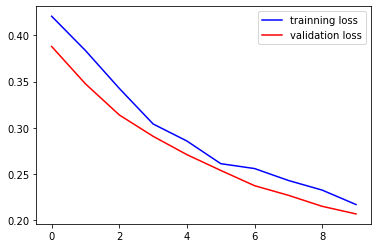

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()